In [1]:
from system import *
from math import floor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as color

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

plt.rcParams.update({'font.size': 18})

e_field = zero_field()
b_field = t89(7)
system  = System(e_field, b_field)

Load IGRF coefficients ...


In [2]:
system.populate_by_eq_pa(5000,
                         delta(10),
                         delta(1e6),
                         uniform(np.radians(1), np.radians(90)),
                         uniform(0, 2 * np.pi)
                        )

system.drop_lost = True

100%|██████████| 5000/5000 [00:03<00:00, 1495.03it/s]


In [3]:
system.solve(2, 1e-4)

100%|██████████| 5000/5000 [05:11<00:00, 16.03it/s]


In [65]:
system.load("EQ_5000_10_1e6_1-90_0-360")

Loaded files containing 916.10 megabytes of information.


In [50]:
system.load("EQ_5000_10_1e6_20_0-360")

Loaded files containing 916.10 megabytes of information.


In [66]:
@njit
def lost_ind(history):
    num_particles = len(history[:, 0, 0, 0])
    steps         = len(history[0, :, 0, 0])
    
    zero_array = np.zeros((4, 3))
    index_list = np.zeros(num_particles) + steps

    for i in range(num_particles):
        for j in range(steps):
            if (history[i, -(j + 1), :, :] == zero_array).all():
                index_list[i] -= 1
            else:
                break

    return index_list

ind_list = lost_ind(system.history)

In [52]:
ind_list[2413]

2000.0

In [67]:
@njit
def per_particle_mu_diffusion(history, intrinsic, delta_t, dt):
    num_particles    = len(history[:, 0, 0, 0])
    delta_t_ind      = int(delta_t / dt)
    steps            = int(len(history[0, :, 0, 0]) / delta_t_ind)
    indices          = np.arange(0, steps) * dt
    
    mom = magnetic_moment(history, intrinsic)
    b   = history[:, :, 2, :]
    bm  = b_mag(history)
    v   = history[:, :, 1, :]

    mus   = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))
    t_coef = np.zeros((num_particles, steps - 1))
    
    for i in range(num_particles):
        b_min = np.amin(bm[i, 0:ind_list[i]])
        
        for j in range(steps - 1): 
            if (j + 1) * delta_t_ind >= ind_list[i]:
                break
                
            mu_begin = mom[i, j * delta_t_ind] * b_min / (intrinsic[i, 0] * dot(v[i, j * delta_t_ind], v[i, j * delta_t_ind]))
            mu_end = mom[i, (j + 1) * delta_t_ind] * b_min / (intrinsic[i, 0] * dot(v[i, (j + 1) * delta_t_ind], v[i, (j + 1) * delta_t_ind]))
            D_uus[i, j] = (mu_end - mu_begin)**2 / (2 * delta_t)
            
            mus[i, j]   = np.degrees(np.arcsin(np.sqrt(2 * mu_begin)))
            if dot(v[i, j * delta_t_ind], b[i, j * delta_t_ind]) < 0:
                mus[i, j] = 180.0 - mus[i, j]
            
            temp_end = np.degrees(np.arcsin(np.sqrt(2 * mu_end)))
            if dot(v[i, (j + 1) * delta_t_ind], b[i, (j + 1) * delta_t_ind]) < 0:
                temp_end = 180.0 - temp_end
            
            t_coef[i, j] = temp_end - mus[i, j]
            
    return mus, D_uus, t_coef

In [68]:
def eq_pa_evolution(history, ics, h_bins, v_bins, T):
    delta_t_4_mus = T / (h_bins + 1)
    mus, D_uus, t_coef = per_particle_mu_diffusion(system.history, system.ics[:, 4, 0:2], delta_t_4_mus, 1e-3)
    
    #pas = eq_pitch_angle_from_moment(history, ics[:, 4, 0:2])
    pas_map = np.zeros((v_bins, h_bins))

    for i, t in enumerate(np.linspace(0, h_bins - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        pas_at_t = mus[:, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 180, num=v_bins + 1))[0])
        
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['font.family'] = 'Liberation Sans'
        
    fig = plt.figure(figsize=(6, 3)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma', norm=color.LogNorm(vmin=1e0, vmax=1e4))
    
    plt.yticks(np.linspace(0, v_bins, 7), [f'{k:.2f}' for k in np.linspace(180, 0, 7)])
    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    
    plt.ylabel(r'Eq. pitch angle $\alpha_0^\circ$')
    plt.xlabel('Time (s)')
    plt.title('1 MeV e$^-$ with initial $\\alpha_0 = 160^\circ$\n T89 ($K_p=7$) + IGRF Model')
    
    cbar = plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Particle count (AU)', rotation=-90, va="bottom")
    
    #plt.tight_layout(pad=2.0)
    plt.show()

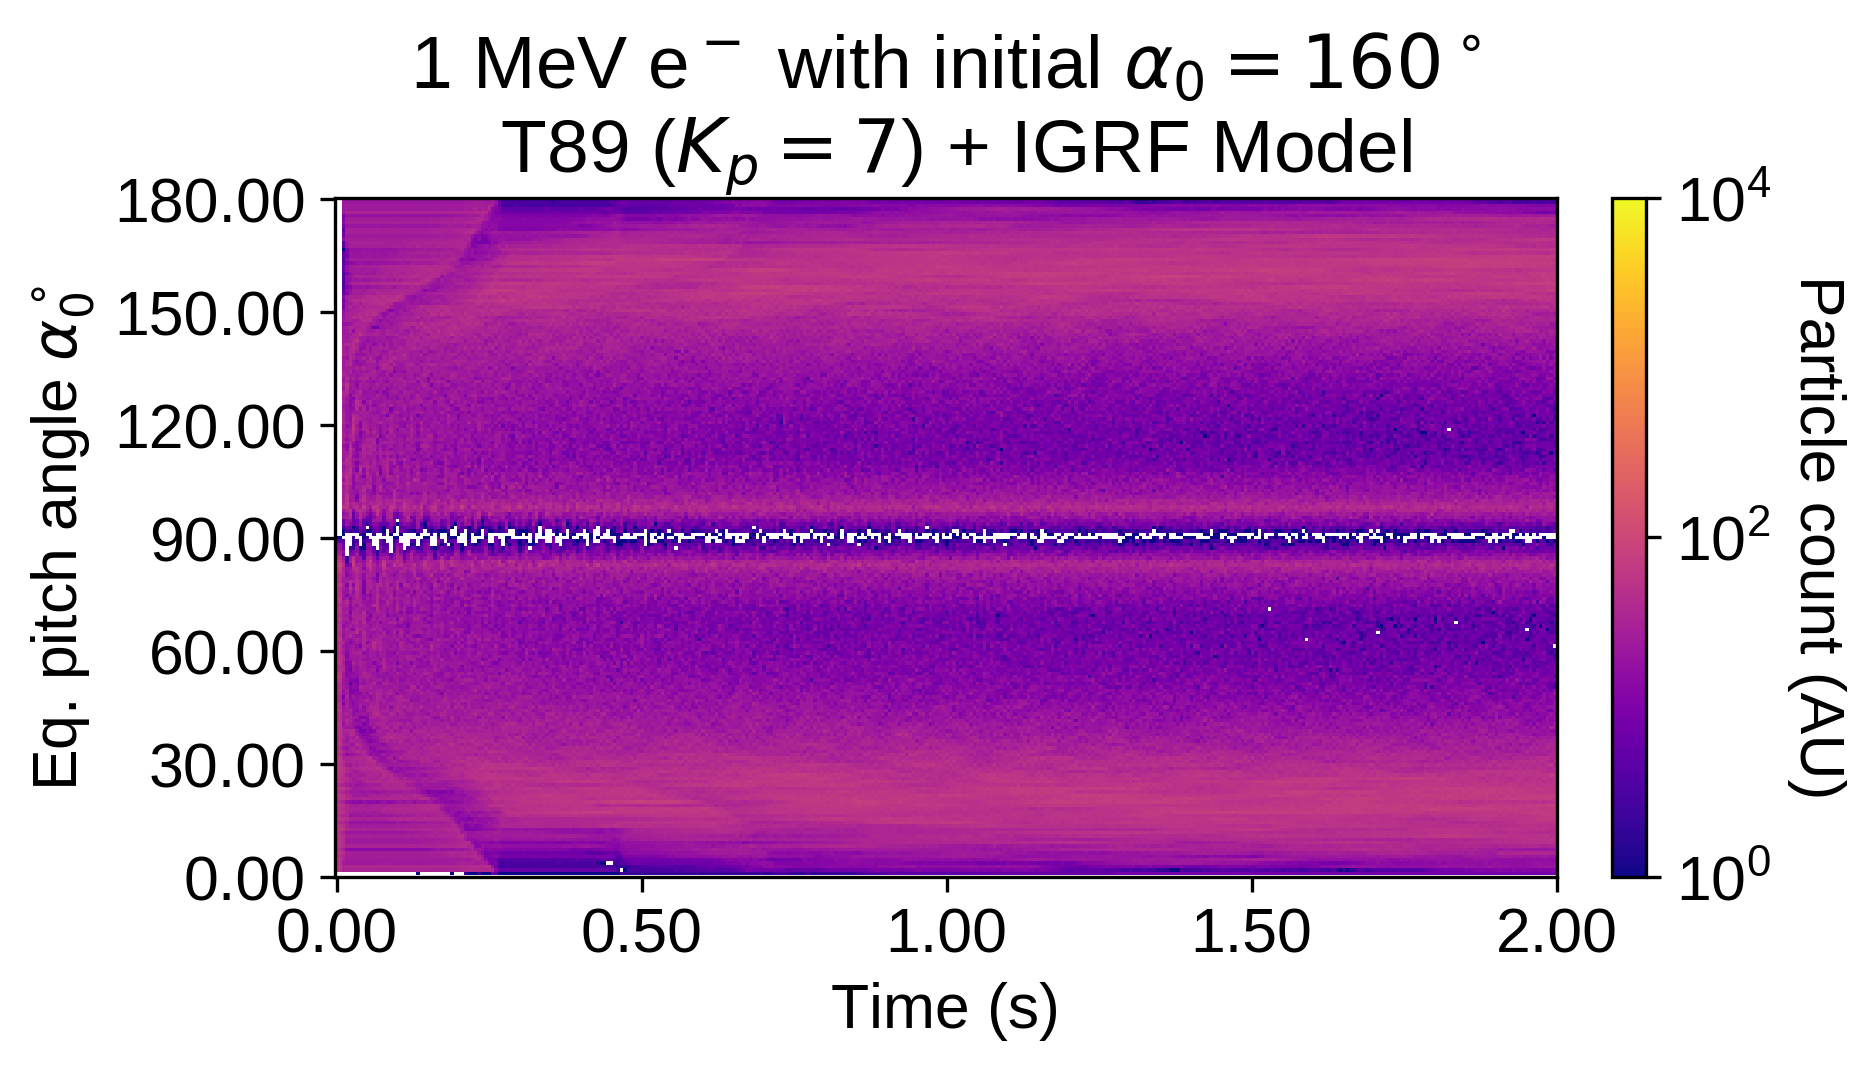

In [69]:
eq_pa_evolution(system.history, system.ics, 360, 200, 2)

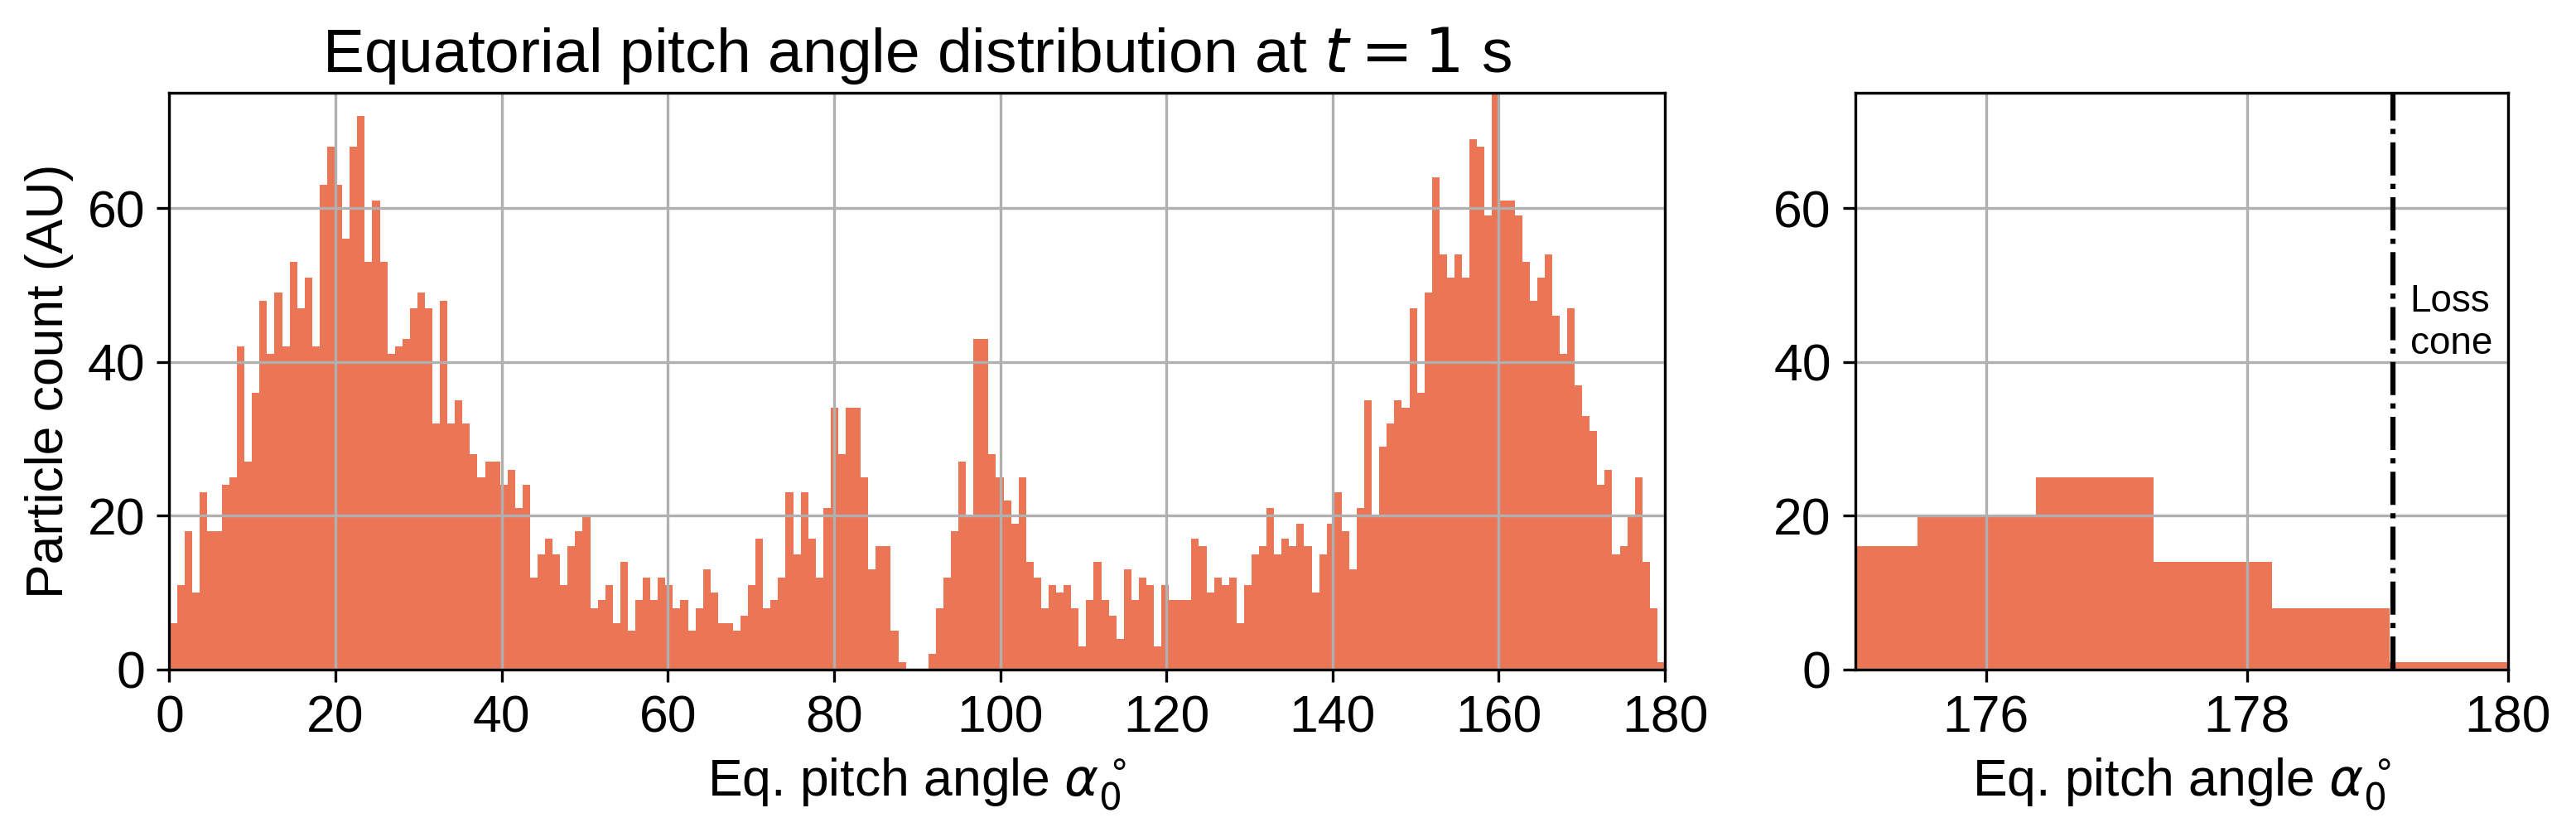

In [85]:
mus, D_uus, t_coef = per_particle_mu_diffusion(system.history, system.ics[:, 4, 0:2], 0.02, 1e-3)

col = plt.cm.plasma(0.66)

plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

fig = plt.figure(figsize=(11, 4))
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])

ax1.hist(mus[:, 51], bins=np.linspace(0, 180, 200), color=col)

ax1.set_xlim([0, 180])
ax1.set_xlabel('Eq. pitch angle $\\alpha_0^\circ$')

ax1.set_ylim([0, 75])
ax1.set_ylabel('Particle count (AU)')

ax1.set_title('Equatorial pitch angle distribution at $t = 1$ s')

ax1.grid()

ax2 = fig.add_subplot(gs[0, 2])

ax2.hist(mus[:, 51], bins=np.linspace(0, 180, 200), color=col)

ax2.set_xlim([175, 180])
ax2.set_xlabel('Eq. pitch angle $\\alpha_0^\circ$')

ax2.set_ylim([0, 75])

ax2.vlines(180 - 0.88, 0, 75, linestyle='-.')

ax2.text(179 + 0.25, 40, "Loss\ncone", verticalalignment='bottom', ha='left', fontsize=11)
ax2.grid()

plt.tight_layout(pad=2.0)
plt.show()

In [243]:
aa = np.zeros(90)

for i in range(99):
    aa += np.histogram(mus[:, i], bins=np.linspace(0, 90, 91))[0]

In [248]:
aa[0] / (99 * 0.0202020202)

7.03030303030303

In [255]:
5000 * aa[0] / (99 * 5000)

7.03030303030303

(-1, 90)

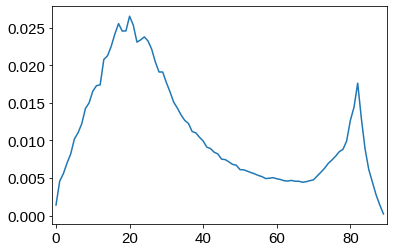

In [254]:
plt.plot(aa / (99 * 5000))
plt.xlim([-1, 90])

In [124]:
lcparts = []

for i in range(99):
    lcparts.append(np.histogram(mus[:, i], bins=np.linspace(0, 90, 104))[0][0])

In [136]:
np.mean(np.diff(lcparts) / (2 / 101))

5.668367346938775

In [148]:
all_bins = np.zeros((103, 99))

for i in range(99):
    all_bins[:, i] = np.histogram(mus[:, i], bins=np.linspace(0, 90, 104))[0]

In [261]:
np.mean(bin_derivs / (2 / 101))[0]

IndexError: invalid index to scalar variable.

In [256]:
bin_derivs = np.diff(all_bins, axis=1)
bin_derivs[:, 0] = 0
#bin_derivs[0, 0] += len(np.argwhere(ind_list < 2000))

In [257]:
np.mean(bin_derivs / (2 / 101), axis=1)

array([  5.66836735, -18.55102041, -21.64285714, -10.82142857,
        -9.2755102 ,  -1.03061224,   7.21428571,  10.82142857,
         5.15306122,  13.91326531,  16.48979592,  13.39795918,
        16.48979592,  24.73469388,  20.6122449 ,  32.46428571,
        35.55612245,  45.8622449 ,  43.28571429,  45.34693878,
        41.2244898 ,  36.07142857,  41.2244898 ,  38.64795918,
        51.53061224,  40.70918367,  30.91836735,  35.55612245,
        23.70408163,  28.85714286,  13.91326531,  11.33673469,
         9.79081633,  21.12755102,  13.39795918,   8.76020408,
        -1.54591837,  -0.51530612,  -0.51530612,   5.15306122,
         5.66836735, -10.82142857, -15.9744898 , -18.03571429,
       -12.88265306, -23.18877551, -10.82142857, -14.42857143,
       -10.30612245,  -2.06122449,  -4.12244898,  -7.21428571,
        -9.2755102 ,  -5.15306122, -12.88265306,  -3.60714286,
        -7.72959184,  -6.18367347, -11.33673469,  -8.24489796,
        -6.69897959,  -7.72959184, -10.82142857, -17.52

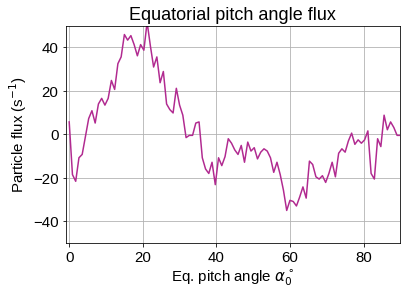

In [258]:
col = plt.cm.plasma(0.4)
fig = plt.figure(figsize=(6, 4))
plt.plot(np.linspace(0, 90, 103), np.mean(bin_derivs / (2 / 101), axis=1), color=col)
plt.xlim([-1, 90])
plt.xlabel('Eq. pitch angle $\\alpha_0^\circ$')
plt.ylim([-50, 50])
plt.ylabel(r'Particle flux (s$^{-1}$)')

plt.title('Equatorial pitch angle flux')
plt.grid()
plt.show()

In [11]:
def D_mumu_evolution(history, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    mus, D_uus, t_coef = per_particle_mu_diffusion(system.history, system.ics[:, 4, 0:2], delta_t, 1e-3)

    D_uu_map = np.zeros((v_bins, h_bins))
    t_coef_map = np.zeros((v_bins, h_bins))

    for i in range(h_bins - 1):
        D_uu_averaged = [[] for k in range(v_bins)]
        t_coef_averaged = [[] for k in range(v_bins)]
        
        bin_size = 90.0 / v_bins
        
        for j in range(len(mus[:, i])):
            bin_ind = int(round((mus[j, i] - bin_size) / bin_size))
            if bin_ind == v_bins:
                bin_ind -= 1
            D_uu_averaged[bin_ind].append(D_uus[j, i])
            t_coef_averaged[bin_ind].append(t_coef[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
        
        for k, d in enumerate(t_coef_averaged):
            if len(d) == 0:
                t_coef_averaged[k].append(0)

        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))
        t_coef_map[:, i] = np.flip(np.array([np.mean(k) for k in t_coef_averaged]))

    fig = plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    im = plt.gca().imshow(D_uu_map, cmap='plasma', norm=color.LogNorm(vmin=1e-4, vmax=1))

    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(90, 0, 5)])
    
    plt.xlabel('Time (s)')
    plt.ylabel(r'$\alpha_0$ (deg)')
    plt.title(r'Evolution of $D_{\alpha_0\alpha_0}(\alpha_0)$')
    
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    
    plt.subplot(1, 2, 2)
    plt.xlim([0, 90])
    plt.xticks(np.linspace(0, 90, 5))
    plt.xlabel(r'$\alpha_0$ (deg)')
    
    plt.ylim([1e-8, 1])
    plt.yticks(np.logspace(-8, 0, 5))
    plt.ylabel(r'$D_{\alpha_0\alpha_0}(\alpha_0)$')

    plt.grid(True)
    plt.gca().xaxis.grid(True)

    D_uu_final = np.zeros(len(D_uu_map[:, 0]))

    for i in range(len(D_uu_final)):
        D_uu_final[i] = np.mean(D_uu_map[i, np.where(D_uu_map[i, :] != 0)])
    
    plt.semilogy(np.linspace(0, 90, v_bins), np.flip(D_uu_final), color='black')
    [i.set_color('black') for i in plt.gca().get_yticklabels()]
    
    ax = plt.gca().twinx()
    
    t_coef_final = np.zeros(len(t_coef_map[:, 0]))

    for i in range(len(D_uu_final)):
        t_coef_final[i] = np.mean(t_coef_map[i, np.where(t_coef_map[i, :] != 0)])
    
    ax.plot(np.linspace(0, 90, v_bins), np.flip(t_coef_final), color='tab:red')
    
    plt.ylim([-20, 20])
    plt.yticks(np.linspace(-20, 20, 5))
    plt.ylabel(r'$\langle\Delta\alpha_0\rangle$ (deg)', color='tab:red')
    [i.set_color('tab:red') for i in ax.get_yticklabels()]
    
    plt.title(r'Diffusion and Transport')
    
    plt.tight_layout(pad=2.0)
    plt.show()
    
    return D_uu_map

In [34]:
@njit
def per_particle_diffusion(history, delta_t, dt):
    num_particles    = len(history[:, 0, 0, 0])
    delta_t_ind      = int(delta_t / dt)
    steps            = int(len(history[0, :, 0, 0]) / delta_t_ind)
    v                = velocity(history)
    indices          = np.arange(0, steps) * dt

    mus    = np.zeros((num_particles, steps - 1)) - 1
    D_uus  = np.zeros((num_particles, steps - 1)) - 1
    t_coef = np.zeros((num_particles, steps - 1)) - 1

    for i in range(num_particles):
        for j in range(steps - 1):
            if (j + 1) * delta_t_ind > ind_list[i]:
                break
                
            v_par_mag_beg   = dot(v[i, j * delta_t_ind], history[i, j * delta_t_ind, 2, :]) / np.linalg.norm(history[i, j * delta_t_ind, 2, :])
            v_par_mag_end   = dot(v[i, (j + 1) * delta_t_ind], history[i, (j + 1) * delta_t_ind, 2, :]) / np.linalg.norm(history[i, (j + 1) * delta_t_ind, 2, :])
            
            mu_begin     = v_par_mag_beg / np.linalg.norm(v[i, j * delta_t_ind])
            mu_end       = v_par_mag_end / np.linalg.norm(v[i, (j + 1) * delta_t_ind])
            D_uus[i, j]  = (mu_end - mu_begin)**2 / (2 * delta_t)
            mus[i, j]    = mu_begin
            t_coef[i, j] = mu_begin - mu_end
            
    return mus, D_uus, t_coef

def D_uu_evolution(history, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    mus, D_uus, t_coef = per_particle_diffusion(history, delta_t, 1e-3)

    D_uu_map = np.zeros((v_bins, h_bins))
    t_coef_map = np.zeros((v_bins, h_bins))

    for i in range(h_bins - 1):
        D_uu_averaged = [[] for k in range(v_bins)]
        t_coef_averaged = [[] for k in range(v_bins)]

        bin_size = 2.0 / v_bins

        for j in range(len(mus[:, i])):
            bin_ind = floor((mus[j, i] + 1) // bin_size)
            
            if mus[j, i] != -1 and D_uus[j, i] != -1 and t_coef[j, i] != -1:
                D_uu_averaged[bin_ind].append(D_uus[j, i])
                t_coef_averaged[bin_ind].append(t_coef[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
                
        for k, d in enumerate(t_coef_averaged):
            if len(d) == 0:
                t_coef_averaged[k].append(0)
                
        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))
        t_coef_map[:, i] = np.flip(np.array([np.mean(k) for k in t_coef_averaged]))
    
    fig = plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    im = plt.gca().imshow(D_uu_map, cmap='plasma')

    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(1, -1, 5)])
    
    plt.xlabel('Time (s)')
    plt.ylabel(r'$\mu = v_{\parallel}/v$')
    plt.title(r'Evolution of $D_{\mu\mu}(\mu)$')
    
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    
    plt.subplot(1, 2, 2)
    plt.xlim([-1, 1])
    plt.xticks(np.linspace(-1, 1, 5))
    plt.xlabel(r'$\mu = v_{\parallel}/v$')
    
    plt.ylim([1e-3, 1e1])
    plt.yticks(np.linspace(1e-3, 1e1, 5))
    plt.ylabel(r'$D_{\mu\mu}(\mu)$')

    plt.grid(True)
    plt.gca().xaxis.grid(True)

    plt.semilogy(np.linspace(-1, 1, v_bins), np.flip(np.mean(D_uu_map[:, -int(v_bins/3):], axis=1)), color='black')
    [i.set_color('black') for i in plt.gca().get_yticklabels()]
    
    ax = plt.gca().twinx()
    ax.plot(np.linspace(-1, 1, v_bins), np.flip(np.mean(t_coef_map[:, -int(v_bins/3):], axis=1)), color='tab:red')
    
    plt.ylim([-20, 20])
    plt.yticks(np.linspace(-20, 20, 5))
    plt.ylabel(r'$\langle\Delta\mu\rangle$', color='tab:red')
    [i.set_color('tab:red') for i in ax.get_yticklabels()]
    
    plt.title(r'Diffusion and Transport')
    
    plt.tight_layout(pad=2.0)
    plt.show()

In [36]:
D_uu_evolution(system.history, 200, 200, 5, 1e-3)

IndexError: index 79 is out of bounds for axis 1 with size 79

In [37]:
def pa_evolution(history, h_bins, v_bins, T):
    pas = pitch_angle(history)
    pas_map = np.zeros((v_bins, h_bins))

    h_max = len(pas[0, :])

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        pas_at_t = pas[:, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 180, num=v_bins + 1), density=True)[0])
        
    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma', norm=color.LogNorm(vmin=1e-4, vmax=1))
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(180, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title('Evolution of pitch angle distribution')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04, norm=color.PowerNorm(gamma=0.3))
    plt.show()

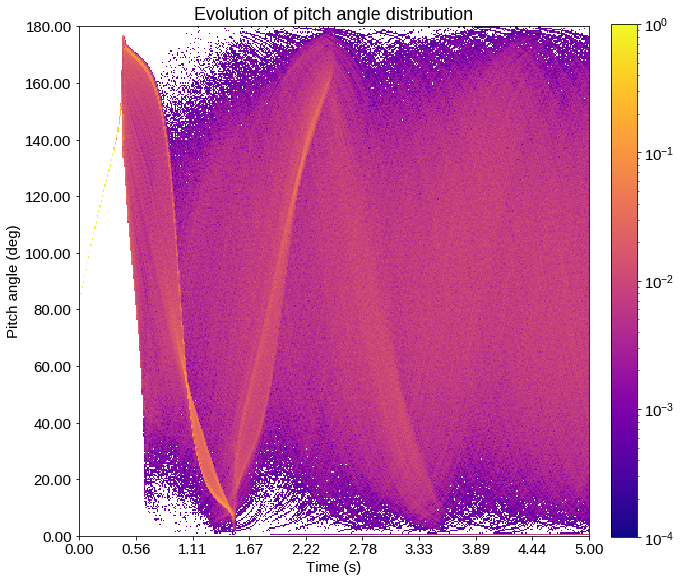

In [39]:
pa_evolution(system.history, 400, 400, 5)

In [22]:
system.history[1559, (76 * int((15 / 200) / 1e-3))]

array([[-7.81161685e+07, -4.17002978e+07,  5.10351310e+04],
       [-1.98249618e+08, -2.00721489e+08, -2.10662288e+06],
       [ 1.45341377e-10,  3.56966206e-11,  5.22991962e-09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [40]:
pa_eq_plane_evolution(system.history, 200, 200, 2, False)

NameError: name 'pa_eq_plane_evolution' is not defined

In [41]:
TDM = D_mumu_evolution(system.history, 100, 100, 15, 1e-3)

IndexError: index 12 is out of bounds for axis 1 with size 12

In [1]:
from system import *
from math import floor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as color

plt.rcParams.update({'font.size': 18})

e_field = zero_field()
b_field = t89(7)
system  = System(e_field, b_field)

Load IGRF coefficients ...


In [2]:
system.populate_by_eq_pa(5000,
                delta(10),
                delta(1e6),
                uniform(0, np.pi / 2),
                uniform(0, 2 * np.pi)
               )

100%|██████████| 5000/5000 [01:03<00:00, 79.24it/s] 


In [3]:
system.solve(2, 1e-4)

100%|██████████| 5000/5000 [05:11<00:00, 16.05it/s]


In [146]:
system.load('EQ_5000_10_1e6_1-90_0-360')

Loaded files containing 916.10 megabytes of information.


In [147]:
system.load('EQ_5000_10_1e6_20_0-360')

Loaded files containing 916.10 megabytes of information.


In [66]:
@njit
def eq_pa_from_mu(history, intrinsic):
    num_particles = len(history[:, 0, 0, 0])
    steps = len(history[0, :, 0, 0])

    bm  = b_mag(history)
    pa  = np.radians(pitch_angle(history))
    
    history_new = np.zeros((num_particles, steps))

    for i in range(num_particles):
        b_min = np.amin(bm[i, :])
        for j in range(steps):
            if j > ind_list[i]:
                break
            if bm[i, j] == 0:
                break
            history_new[i, j] = np.arcsin(np.sqrt(b_min / bm[i, j]) * np.sin(pa[i, j]))
            
    return np.degrees(history_new)

In [67]:
pas = pitch_angle(system.history)
zs  = system.history[:, :, 0, 2]
mus = eq_pa_from_mu(system.history, system.ics[:, 4, 0:2])#eq_pitch_angle_from_moment(system.history, system.ics[:, 4, 0:2])
bm  = b_mag(system.history)

In [68]:
pa_sign_change = ((np.roll(np.sign(pas - 90), 1) - np.sign(pas - 90)) != 0).astype(int)
z_sign_change  = ((np.roll(np.sign(zs - 90), 1) - np.sign(zs - 90)) != 0).astype(int)

mirror_points = []
crossings = []

for i in range(len(pa_sign_change[:, 0])):
    if np.abs(pas[i, 0] - 90) < 5:
        pa_sign_change[i, 0] = 1
    else:
        pa_sign_change[i, 0] = 0
        
    mirror_points.append(np.argwhere(pa_sign_change[i, :] == 1))
    
for i in range(len(z_sign_change[:, 0])):
    z_sign_change[i, 0] = 0
    crossings.append(np.argwhere(z_sign_change[i, :] == 1))

In [69]:
for m in range(len(mirror_points)):
    if mirror_points[m][0] == 0:
        mirror_points[m] = np.delete(mirror_points[m], 0)

In [80]:
t    = []
eqpa = []

for p in range(len(mirror_points)):
    b_min = np.amin(bm[p, 0:int(ind_list[p])])
    for m in range(len(mirror_points[p])):
        if bm[p, mirror_points[p][m]] == 0:
            break
        t.append(mirror_points[p][m] * 1e-3)
        eqpa.append(np.degrees(np.arcsin(np.sqrt(b_min / bm[p, mirror_points[p][m]]) * np.sin(np.radians(pas[p, mirror_points[p][m]])))))
    eqpa.append(np.degrees(np.arcsin(np.sqrt(b_min / bm[p, int(ind_list[p] - 1)]) * np.sin(np.radians(pas[p, int(ind_list[p] - 1)])))))

In [81]:
bins = 100
k = 2.0 / 100

eqpa_dist_test = [[] for k in range(100)]

for i in range(len(t)):
    bin_ind = floor(t[i] / k)
    eqpa_dist_test[bin_ind].append(float(eqpa[i]))

NameError: name 'v_bins' is not defined

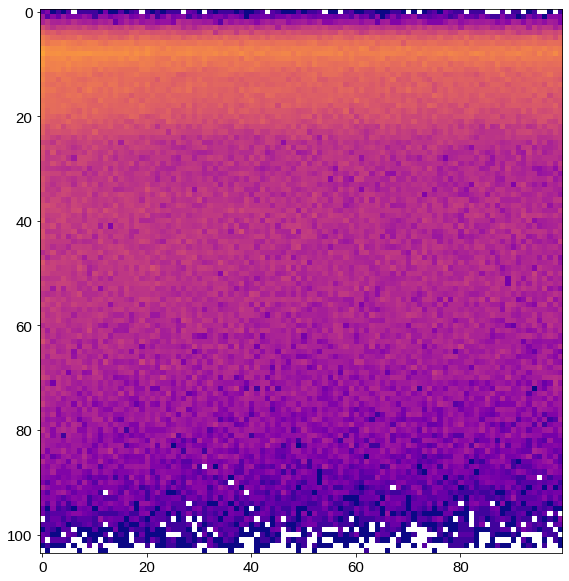

In [101]:
pas_map = np.zeros((104, 100))

h_max = len(pas[0, :])

for i in range(100):
    pas_at_t = eqpa_dist_test[i]
    pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 90, 105))[0])

fig = plt.figure(figsize=(10, 10)) 
cax = plt.gca()

im = cax.imshow(pas_map, cmap='plasma', norm=color.LogNorm(vmin=1, vmax=1e3))

plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(180, 0, 10)])
plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])

plt.ylabel('Pitch angle (deg)')
plt.xlabel('Time (s)')
plt.title('Evolution of pitch angle distribution')

plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04, norm=color.PowerNorm(gamma=0.3))
plt.show()

In [102]:
np.sum(pas_map, axis=1) / 2.0

array([  79.5,  254.5,  532. , 1126. , 1889. , 3050.5, 4294.5, 5641.5,
       6346. , 5136.5, 4531. , 3855.5, 3310.5, 3129. , 3151. , 3126.5,
       2876.5, 2743.5, 2613.5, 2358. , 2117.5, 1938. , 1600.5, 1451. ,
       1211.5, 1071. , 1068.5,  986.5,  975.5,  985.5,  895.5,  935. ,
        924.5,  927. ,  958. ,  987.5,  991.5, 1013.5, 1083. , 1043. ,
        980.5,  973.5,  963.5,  937.5,  941. ,  932. ,  968. ,  918.5,
        961.5,  956.5,  910.5,  883. ,  935.5,  866. ,  827.5,  897. ,
        821.5,  808.5,  821.5,  795.5,  745. ,  763. ,  709. ,  703.5,
        707.5,  657.5,  656. ,  663.5,  647. ,  619. ,  625. ,  534. ,
        539. ,  558.5,  528. ,  489.5,  464.5,  458.5,  432. ,  452.5,
        440.5,  397. ,  387. ,  382. ,  386. ,  344.5,  323.5,  311.5,
        285.5,  248. ,  251.5,  225.5,  212. ,  198.5,  185. ,  149. ,
        148.5,  132. ,  104.5,   81.5,   68. ,   59. ,   40. ,    6.5])

In [51]:
def find_mps_for_xing(xings, mps):
    xing_mps = []
    seq_mps  = []
    
    for xing in xings:
        for i in range(len(mps) - 1):
            if xing > mps[i][0] and xing < mps[i + 1][0]:
                if len(xing_mps) > 0:
                    if mps[i][0] != xing_mps[-1][0] and mps[i + 1][0] != xing_mps[-1][1]:
                        xing_mps.append([mps[i][0], mps[i + 1][0]])
                else:
                    xing_mps.append([mps[i][0], mps[i + 1][0]])
                
    seq_mps.append(xing_mps[0][0])
    
    for i in range(len(xing_mps)):
        seq_mps.append(xing_mps[i][1])
                
    return xing_mps, seq_mps

In [52]:
diffs = []
tcoef = []
us    = []

first_us = []

for j in range(len(system.history[:, 0, 0, 0])):
    pa, se = find_mps_for_xing(crossings[j], mirror_points[j])
    for i in range(len(se) - 1):
        temp_bmin = np.amin(bm[j, se[i]:se[i + 1]])
        mu_beg = 0.5 * np.sin(np.radians(pas[j, se[i]]))**2 * (temp_bmin / bm[j, se[i]])
        mu_end = 0.5 * np.sin(np.radians(pas[j, se[i + 1]]))**2 * (temp_bmin / bm[j, se[i + 1]])
        delta_mu_sq = (mu_end - mu_beg)**2
        delta_t     = 1e-3 * (se[i + 1] - se[i])
        
        diffs.append(delta_mu_sq / delta_t)
        us.append(np.degrees(np.arcsin(np.sqrt(2 * mu_beg))))
        if i == 1:
            first_us.append(np.degrees(np.arcsin(np.sqrt(2 * mu_beg))))
        tcoef.append(mu_end - mu_beg)

/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


IndexError: list index out of range

In [41]:
b = 95
bins = 1000
binned_diffs = [[] for k in range(bins)]
binned_tcoef = [[] for k in range(bins)]
k = b / bins

for j in range(len(us)):
    bin_ind = int(round(us[j] / k))
    binned_diffs[bin_ind].append(diffs[j])
    binned_tcoef[bin_ind].append(tcoef[j])
    
for j in range(len(binned_diffs)):
    if len(binned_diffs[j]) == 0:
        binned_diffs[j].append(0)
    if len(binned_tcoef[j]) == 0:
        binned_tcoef[j].append(0)
        
    binned_diffs[j] = np.mean(binned_diffs[j])
    binned_tcoef[j] = np.mean(binned_tcoef[j])

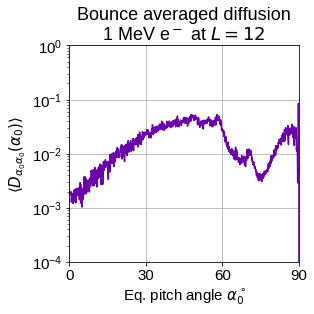

In [48]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

fig = plt.figure(figsize=(5, 5))

col = plt.cm.plasma(np.linspace(0.2, 0.6, 2))

plt.semilogy(np.linspace(0, b, bins), binned_diffs, color=col[0])

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'Eq. pitch angle $\alpha_0^\circ$')

plt.ylim([1e-4, 1])
plt.yticks(np.logspace(-4, 0, 5))
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}(\alpha_0)\rangle$')

plt.title('Bounce averaged diffusion\n1 MeV e$^-$ at $L = 12$')

plt.grid()
plt.tight_layout(pad=2.0)
plt.show()

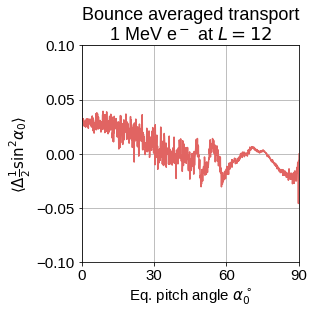

In [55]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

fig = plt.figure(figsize=(5, 5))

col = plt.cm.plasma(np.linspace(0.2, 0.6, 2))

plt.plot(np.linspace(0, b, bins), binned_tcoef, color=col[1])

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'Eq. pitch angle $\alpha_0^\circ$')

plt.ylim([-0.1, 0.1])
plt.yticks(np.linspace(-0.1, 0.1, 5))
plt.ylabel(r'$\langle \Delta \frac{1}{2}\sin^2\alpha_0 \rangle$')

plt.title('Bounce averaged transport\n1 MeV e$^-$ at $L = 12$')

plt.grid()
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    im = plt.gca().imshow(D_uu_map, cmap='plasma')

    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(1, -1, 5)])
    
    plt.xlabel('Time (s)')
    plt.ylabel(r'$\mu = v_{\parallel}/v$')
    plt.title(r'Evolution of $D_{\mu\mu}(\mu)$')
    
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    
    plt.subplot(1, 2, 2)
    plt.xlim([-1, 1])
    plt.xticks(np.linspace(-1, 1, 5))
    plt.xlabel(r'$\mu = v_{\parallel}/v$')
    
    plt.ylim([1e-3, 1e1])
    plt.yticks(np.linspace(1e-3, 1e1, 5))
    plt.ylabel(r'$D_{\mu\mu}(\mu)$')

    plt.grid(True)
    plt.gca().xaxis.grid(True)

    plt.semilogy(np.linspace(-1, 1, v_bins), np.flip(np.mean(D_uu_map[:, -int(v_bins/3):], axis=1)), color='black')
    [i.set_color('black') for i in plt.gca().get_yticklabels()]
    
    ax = plt.gca().twinx()
    ax.plot(np.linspace(-1, 1, v_bins), np.flip(np.mean(t_coef_map[:, -int(v_bins/3):], axis=1)), color='tab:red')
    
    plt.ylim([-20, 20])
    plt.yticks(np.linspace(-20, 20, 5))
    plt.ylabel(r'$\langle\Delta\mu\rangle$', color='tab:red')
    [i.set_color('tab:red') for i in ax.get_yticklabels()]
    
    plt.title(r'Diffusion and Transport')
    
    plt.tight_layout(pad=2.0)
    plt.show()

In [279]:
abcd = [[] for k in range(200)]

for j in range(len(system.history[:, 0, 0, 0])):
    pa, se = find_mps_for_xing(crossings[j], mirror_points[j])
    for i in range(len(se) - 1):
        abcd[i].append(mus[j, se[i]])

100


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  7.,
         8., 11., 26.,  7., 17., 13.,  8.,  2.,  0.,  0.]),
 array([ 0.        ,  1.83673469,  3.67346939,  5.51020408,  7.34693878,
         9.18367347, 11.02040816, 12.85714286, 14.69387755, 16.53061224,
        18.36734694, 20.20408163, 22.04081633, 23.87755102, 25.71428571,
        27.55102041, 29.3877551 , 31.2244898 , 33.06122449, 34.89795918,
        36.73469388, 38.57142857, 40.40816327, 42.24489796, 44.08163265,
        45.91836735, 47.75510204, 49.59183673, 51.42857143, 53.26530612,
        55.10204082, 56.93877551, 58.7755102 , 60.6122449 , 62.44897959,
        64.28571429, 66.12244898, 67.95918367, 69.79591837, 71.63265306,
        73.46938776, 75.30612245, 77.14285714, 78.97959184, 80.81632653,
        82.65306122, 84.48979592, 86.32653061, 88.16326531, 90. 

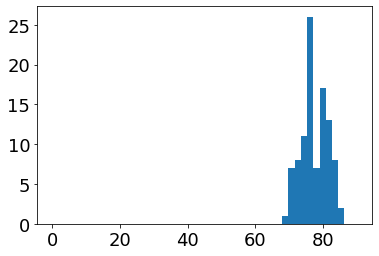

In [308]:
c = 70
print(len(abcd[c]))
plt.hist(abcd[c], bins=np.linspace(0, 90, 50))